In [4]:
import pandas as pd
import numpy as np

#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup

import torch as th
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_df = pd.read_csv('data/processed_train.csv')
test_df = pd.read_csv('data/processed_test.csv')

In [5]:
train_df['text'] = train_df['text'].str.replace('[^\w\s]','')
test_df['text'] = test_df['text'].str.replace('[^\w\s]','')

train_df['text'] = train_df['text'].str.split()
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stopwords])
train_df['text'] = train_df['text'].apply(lambda x: ' '.join(x))

test_df['text'] = test_df['text'].str.split()
test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stopwords])
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(x))

### Encoding Texts 

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
seq_len = 128

train_df['ids'] = train_df['text'].apply(lambda x: tokenizer.encode(x, 
                                                                    add_special_tokens = True, 
                                                                    max_length = seq_len, 
                                                                    truncation=True))

test_df['ids'] = test_df['text'].apply(lambda x: tokenizer.encode(x, 
                                                                  add_special_tokens = True, 
                                                                  max_length = seq_len, 
                                                                  truncation=True))

train_df['ids'] = train_df['ids'].apply(lambda x: [tokenizer.pad_token_id]*(seq_len - len(x)) + x)
test_df['ids'] = test_df['ids'].apply(lambda x: [tokenizer.pad_token_id]*(seq_len - len(x)) + x)

#### Creating Attention Masks

In [ ]:
train_att_masks = []
train_df['ids'].apply(lambda x: train_att_masks.append([int(token > 0) for token in x]))

test_att_masks = []
test_df['ids'].apply(lambda x: test_att_masks.append([int(token > 0) for token in x]))

### Splitting training dataset for validation

In [9]:
x = train_df['ids'].values
y = train_df['label'].values

x_test = test_df['ids'].values
y_test = test_df['label'].values

x_train, x_val, y_train, y_val = train_test_split(x, 
                                                  y, 
                                                  test_size=.2, 
                                                  stratify=y, 
                                                  random_state = 42)

train_att_masks, val_att_masks, _, _ = train_test_split(train_att_masks, 
                                                         y, 
                                                         test_size=.2, 
                                                         stratify=y, 
                                                         random_state = 42)

x_train = np.stack(x_train)
x_val = np.stack(x_val)
x_test = np.stack(x_test)
train_att_masks = np.stack(train_att_masks)
val_att_masks = np.stack(val_att_masks)
test_att_masks = np.stack(test_att_masks)

print('Train size: %i'%(len(x_train)))
print('Validation size: %i'%(len(x_val)))
print('Test size: %i'%(len(x_test)))

Train size: 20000
Validation size: 5000
Test size: 25000


### Creating Torch Datasets

In [10]:
x_train = th.from_numpy(x_train).to(device)
x_val = th.from_numpy(x_val).to(device)
x_test = th.from_numpy(x_test).to(device)

y_train = th.from_numpy(y_train).to(device)
y_val = th.from_numpy(y_val).to(device)
y_test = th.from_numpy(y_test).to(device)

train_att_masks = th.from_numpy(train_att_masks).to(device)
val_att_masks = th.from_numpy(val_att_masks).to(device)
test_att_masks = th.from_numpy(test_att_masks).to(device)

batch_size = 16

train_data = TensorDataset(x_train, y_train, train_att_masks)
train_loader = DataLoader(train_data,
                          batch_size=batch_size)

val_data = TensorDataset(x_val, y_val, val_att_masks)
val_loader = DataLoader(val_data,
                        batch_size=batch_size)

test_data = TensorDataset(x_test, y_test, test_att_masks)
test_loader = DataLoader(test_data,
                         batch_size=batch_size)

### Getting BERT

In [11]:
config = BertConfig.from_pretrained('bert-base-uncased', 
                                    num_labels = 2,  
                                    output_attentions = False,
                                    output_hidden_states = False, 
                                    hidden_dropout_prob=.3, 
                                    attention_probs_dropout_prob = .3)

net = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    config=config).to(device)

net

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
epochs = 50
lr = 2e-5
early_stop_rounds = 5

opt = AdamW(net.parameters(),lr=lr)
sched = get_linear_schedule_with_warmup(opt, 
                                        num_warmup_steps=0,
                                        num_training_steps=len(train_loader)*epochs
                                        )


### Fine-Tuning BERT 

In [13]:
predict_logits = lambda logits: th.argmax(logits, axis=1).flatten()

losses = []
val_acc = []

early_stop_acc = -np.inf
early_stop_rounds_count = 0

for epoch in range(epochs):
  print('Epoch: %i'%(epoch+1))

  net.train()

  batch_losses = []
  for train in tqdm(train_loader):
    train_feats = train[0]
    train_labels = train[1]
    train_mask = train[2]
    
    net.eval()

    output = net(train_feats, 
                 labels=train_labels,
                 attention_mask=train_mask, 
                 token_type_ids=None)
    
    loss = output[0]

    opt.zero_grad()
    loss.backward()
    opt.step()

    sched.step()

    batch_losses.append(loss.item())

    loss_mean = np.array(batch_losses).mean()

  losses.append(loss_mean)
  print('LOSS: %f'%(loss_mean))

  if epoch % 5 == 0:
    path = 'models/bert_model_checkpoint.pt'
    th.save({'epoch': epoch,
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': opt.state_dict(),
             'loss': loss_mean,
            }, path)
    
  net.eval()

  y_pred = []
  y_true = []

  for val in val_loader:
    val_feats = val[0]
    val_labels = val[1].cpu().numpy()
    val_mask = val[2]

    val_logits = net(val_feats,
                     attention_mask=val_mask, 
                     token_type_ids=None)[0]

    y_true.extend(val_labels)
    y_pred.extend(predict_logits(val_logits).cpu().numpy())

  acc = accuracy_score(y_true, y_pred)
  val_acc.append(acc)
  print('VALIDATION ACC: %.4f'%(acc))

  if acc > early_stop_acc:
    early_stop_acc = acc
    
    path = 'models/bert_model_early_stop.pt'
    th.save({'epoch': epoch,
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': opt.state_dict(),
             'loss': loss_mean,
             'val_acc':acc
            }, path)
    
    early_stop_rounds_count = 0
  else:
    early_stop_rounds_count += 1

  if early_stop_rounds_count == early_stop_rounds:
    print('Early stopping...')
    print('Best acc:  %.4f'%(early_stop_acc))
    break

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 1


100%|██████████| 1250/1250 [07:34<00:00,  2.75it/s]


LOSS: 0.357728
VALIDATION ACC: 0.8790


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch: 2


100%|██████████| 1250/1250 [07:35<00:00,  2.75it/s]


LOSS: 0.155948


  0%|          | 0/1250 [00:00<?, ?it/s]

VALIDATION ACC: 0.8702
Epoch: 3


100%|██████████| 1250/1250 [07:35<00:00,  2.75it/s]


LOSS: 0.070031


  0%|          | 0/1250 [00:00<?, ?it/s]

VALIDATION ACC: 0.8588
Epoch: 4


100%|██████████| 1250/1250 [07:35<00:00,  2.75it/s]


LOSS: 0.041275


  0%|          | 0/1250 [00:00<?, ?it/s]

VALIDATION ACC: 0.8604
Epoch: 5


100%|██████████| 1250/1250 [07:35<00:00,  2.75it/s]


LOSS: 0.029846


  0%|          | 0/1250 [00:00<?, ?it/s]

VALIDATION ACC: 0.8530
Epoch: 6


100%|██████████| 1250/1250 [07:35<00:00,  2.75it/s]


LOSS: 0.021002
VALIDATION ACC: 0.8668
Early stopping...
Best acc:  0.8790


In [14]:
early_stop_net = th.load('models/bert_model_early_stop.pt')

config = BertConfig.from_pretrained('bert-base-uncased', 
                                    num_labels = 2,  
                                    output_attentions = False,
                                    output_hidden_states = False, 
                                    hidden_dropout_prob=.3, 
                                    attention_probs_dropout_prob = .3)

net = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    config=config).to(device)

net.load_state_dict(early_stop_net['model_state_dict'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

### Model Evaluation

[Text(0, 0.5, 'Validation accuracy'), Text(0.5, 0, 'Epoch')]

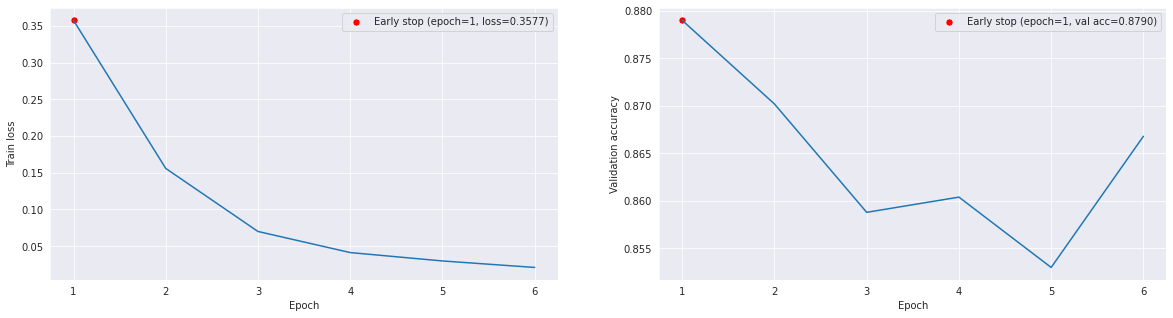

In [15]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
ax = sns.scatterplot(x=[early_stop_net['epoch']+1], 
                     y=[early_stop_net['loss']], 
                     color='red', 
                     s=50)
ax.legend(['Early stop (epoch=%i, loss=%.4f)'%(early_stop_net['epoch']+1, 
                                               early_stop_net['loss'])])
ax = sns.lineplot(x=range(1, epoch+2), y=losses, ax=ax)

ax.set(xlabel='Epoch', ylabel='Train loss')

plt.subplot(1, 2, 2)
ax = sns.scatterplot(x=[early_stop_net['epoch']+1], 
                     y=[early_stop_net['val_acc']], 
                     color='red', 
                     s=50)
ax.legend(['Early stop (epoch=%i, val acc=%.4f)'%(early_stop_net['epoch']+1, 
                                               early_stop_net['val_acc'])])
ax = sns.lineplot(x=range(1, epoch+2), y=val_acc, ax=ax)
ax.set(xlabel='Epoch', ylabel='Validation accuracy')

              precision    recall  f1-score   support

           0    0.87277   0.90272   0.88749     12500
           1    0.89926   0.86840   0.88356     12500

    accuracy                        0.88556     25000
   macro avg    0.88601   0.88556   0.88553     25000
weighted avg    0.88601   0.88556   0.88553     25000



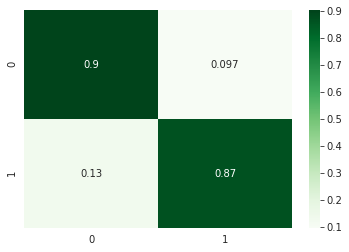

In [16]:
y_pred = []
y_true = []

for test in test_loader:
  test_feats = test[0]
  test_labels = test[1].cpu().numpy()
  test_mask = test[2]

  test_logits = net(test_feats,
                    attention_mask=test_mask, 
                    token_type_ids=None)[0]

  y_true.extend(test_labels)
  y_pred.extend(predict_logits(test_logits).cpu().numpy())

print(classification_report(y_true, y_pred, digits=5))

cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens')